In [1]:
import warnings

warnings.simplefilter('ignore')

import os
import re
import gc
import json

import numpy as np
import pandas as pd

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF系统认证风险预测/train_dataset.csv', sep='\t')
test = pd.read_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF系统认证风险预测/test_dataset.csv', sep='\t')

In [3]:
train.head(5).append(train.tail(5))

session_id           op_date user_name action  \
0      access:test_d:20180101111639:bBp1    2018/1/1 11:16    test_d  login   
1      access:test_d:20180101121524:OBSg    2018/1/1 12:15    test_d  login   
2      access:test_d:20180101151333:BpQN    2018/1/1 15:13    test_d  login   
3      access:test_d:20180101124502:hYQm    2018/1/1 12:45    test_d    sso   
4      access:test_d:20180101202749:FkDK    2018/1/1 20:27    test_d    sso   
15011  access:test_c:20191023144109:DuOm  2019/10/23 14:41    test_c  login   
15012  access:test_c:20191023201859:lxXK  2019/10/23 20:18    test_c  login   
15013  access:test_c:20191023152336:EUlA  2019/10/23 15:23    test_c    sso   
15014  access:test_c:20191023123533:MQfw  2019/10/23 12:35    test_c  login   
15015  access:test_c:20191023102054:QPZI  2019/10/23 10:20    test_c    sso   

      auth_type               ip ip_location_type_keyword ip_risk_level  \
0           otp  192.168.100.101                       内网            1级   
1            qr  192.168.100.101                       内网            1级   
2            qr  192.168.100.101                       内网            1级   
3           NaN  192.168.100.101                       内网            1级   
4           NaN  192.168.100.101                       内网            1级   
15011        qr    27.10.135.254                     代理IP            3级   
15012       otp    27.10.135.254                     代理IP            3级   
15013       NaN    27.10.135.254                     代理IP            3级   
15014       pwd    27.10.135.254                     代理IP            3级   
15015       NaN    27.10.135.254                     代理IP            3级   

                                                location client_type  \
0      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
1      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
2      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
3      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
4      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
15011  {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
15012  {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
15013  {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
15014  {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
15015  {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   

      browser_source    device_model  os_type        os_version browser_type  \
0            desktop  think_pad_e460  windows        windows 10       chrome   
1            desktop  think_pad_e460  windows        windows 10         edge   
2            desktop  think_pad_e460  windows        windows 10       chrome   
3            desktop  think_pad_e460  windows        windows 10         edge   
4            desktop  think_pad_e460  windows        windows 10         edge   
15011        desktop         macbook    macOS  macOS Big Sur 11       safari   
15012        desktop         macbook    macOS  macOS Big Sur 11       safari   
15013        desktop         macbook    macOS  macOS Big Sur 11       safari   
15014        desktop         macbook    macOS  macOS Big Sur 11       safari   
15015        desktop         macbook    macOS  macOS Big Sur 11       safari   

      browser_version bus_system_code   op_target  risk_label  
0           chrome 90        coremail  management           0  
1             edge 93      order-mgnt       sales           0  
2           chrome 90      order-mgnt       sales           0  
3             edge 93              oa  management           0  
4             edge 93      order-mgnt       sales           0  
15011       safari 13   reimbursement     finance           1  
15012       safari 13      order-mgnt       sales           0  
15013       safari 13      order-mgnt       sales           0  
15014       safari 13      order-mgnt       sales           0  
15015       safari 1

In [9]:
test.head(5).append(test.tail(5))

session_id           op_date user_name action  \
0     access:test_c:20191023212545:H2in  2019/10/23 21:25    test_c    sso   
1     access:test_c:20191023095634:ylxO   2019/10/23 9:56    test_c    sso   
2     access:test_c:20191023104233:tc9Y  2019/10/23 10:42    test_c  login   
3     access:test_c:20191023142416:8rjC  2019/10/23 14:24    test_c    sso   
4     access:test_c:20191023210513:cOCi  2019/10/23 21:05    test_c    sso   
9995  access:test_a:20201231155549:fSaL  2020/12/31 15:55    test_a    sso   
9996  access:test_a:20201231224950:uD7Y  2020/12/31 22:49    test_a    sso   
9997  access:test_a:20201231115831:TjRH  2020/12/31 11:58    test_a    sso   
9998  access:test_a:20201231193033:8VtL  2020/12/31 19:30    test_a  login   
9999  access:test_a:20201231145833:3jgA  2020/12/31 14:58    test_a  login   

     auth_type               ip ip_location_type_keyword ip_risk_level  \
0          NaN    27.10.135.254                     代理IP            3级   
1          NaN    27.10.135.254                     代理IP            3级   
2          sms    27.10.135.254                     代理IP            3级   
3          NaN    27.10.135.254                     代理IP            3级   
4          NaN    27.10.135.254                     代理IP            3级   
9995       NaN  192.168.100.101                       内网            1级   
9996       NaN  192.168.100.101                       内网            1级   
9997       NaN  192.168.100.101                       内网            1级   
9998       otp  192.168.100.101                       内网            1级   
9999       otp  192.168.100.101                       内网            1级   

                                               location client_type  \
0     {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
1     {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
2     {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
3     {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
4     {"first_lvl":"重庆","sec_lvl":"重庆市","third_lvl":...         web   
9995  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
9996  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
9997  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
9998  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   
9999  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl...         web   

     browser_source    device_model  os_type        os_version browser_type  \
0           desktop         macbook    macOS  macOS Big Sur 11       safari   
1           desktop         macbook    macOS  macOS Big Sur 11       safari   
2           desktop         macbook    macOS  macOS Big Sur 11       safari   
3           desktop         macbook    macOS  macOS Big Sur 11       safari   
4           desktop         macbook    macOS  macOS Big Sur 11       safari   
9995        desktop  think_pad_e460  windows        windows 10       chrome   
9996        desktop  think_pad_e460  windows        windows 10         edge   
9997        desktop  think_pad_e460  windows        windows 10         edge   
9998        desktop  think_pad_e460  windows        windows 10       chrome   
9999        desktop  think_pad_e460  windows        windows 10         edge   

     browser_version bus_system_code   op_target  
0          safari 13      order-mgnt       sales  
1          safari 13      order-mgnt       sales  
2          safari 13      order-mgnt       sales  
3          safari 13        coremail  management  
4          safari 13   reimbursement     finance  
9995       chrome 90              oa  management  
9996         edge 93      order-mgnt       sales  
9997         edge 93             crm       sales  
9998       chrome 90      order-mgnt       sales  
9999         edge 93      order-mgnt       sales

In [5]:
train.shape

(15016, 19)

In [6]:
test.shape

(10000, 18)

In [7]:
train.isnull().sum()

session_id                     0
op_date                        0
user_name                      0
action                         0
auth_type                   7535
ip                             0
ip_location_type_keyword       0
ip_risk_level                  0
location                       0
client_type                    0
browser_source                 0
device_model                   0
os_type                        0
os_version                     0
browser_type                   0
browser_version                0
bus_system_code                0
op_target                      0
risk_label                     0
dtype: int64

In [8]:
test.isnull().sum()

session_id                     0
op_date                        0
user_name                      0
action                         0
auth_type                   5065
ip                             0
ip_location_type_keyword       0
ip_risk_level                  0
location                       0
client_type                    0
browser_source                 0
device_model                   0
os_type                        0
os_version                     0
browser_type                   0
browser_version                0
bus_system_code                0
op_target                      0
dtype: int64

In [38]:
train['risk_label'].sum()/train.shape[0]

0.19579115610015982

In [19]:
print(set(train['user_name']))
print(set(test['user_name']))

{'test_d', 'test_a', 'test_c', 'test_e', 'test_g', 'test_f', 'test_b'}
{'test_d', 'test_a', 'test_c', 'test_e', 'test_g', 'test_f', 'test_b'}


In [20]:
train.groupby(['user_name']).agg({'risk_label':'mean','user_name':'count'}).rename(columns={'risk_label':'mean','user_name':'count'}).reset_index()

user_name  mean  count
0    test_a 0.194   6147
1    test_b 0.200   2285
2    test_c 0.200   2380
3    test_d 0.191   1567
4    test_e 0.199    900
5    test_f 0.192   1149
6    test_g 0.196    588

In [23]:
test.groupby(['user_name']).agg({'user_name':'count'}).rename(columns={'user_name':'count'}).reset_index()

user_name  count
0    test_a   2739
1    test_b   1925
2    test_c   2516
3    test_d   1258
4    test_e    813
5    test_f    590
6    test_g    159

In [24]:
print(set(train['action']))
print(set(test['action']))

{'sso', 'login'}
{'sso', 'login'}


In [21]:
train.groupby(['action']).agg({'risk_label':'mean','action':'count'}).rename(columns={'risk_label':'mean','action':'count'}).reset_index()

action  mean  count
0  login 0.193   7481
1    sso 0.198   7535

In [25]:
test.groupby(['action']).agg({'action':'count'}).rename(columns={'risk_label':'mean','action':'count'}).reset_index()

action  count
0  login   4935
1    sso   5065

In [31]:
train['auth_type'].fillna('na',inplace=True)
test['auth_type'].fillna('na',inplace=True)

In [32]:
train.groupby(['auth_type']).agg({'risk_label':'mean','auth_type':'count'}).rename(columns={'risk_label':'mean','auth_type':'count'}).reset_index()

auth_type  mean  count
0        na 0.198   7535
1       otp 0.192   1833
2       pwd 0.200   1876
3        qr 0.189   1906
4       sms 0.192   1866

In [34]:
test.groupby(['auth_type']).agg({'auth_type':'count'}).rename(columns={'auth_type':'count'}).reset_index()

auth_type  count
0        na   5065
1       otp   1231
2       pwd   1274
3        qr   1177
4       sms   1253

In [35]:
train.groupby(['ip_location_type_keyword']).agg({'risk_label':'mean','ip_location_type_keyword':'count'}).rename(columns={'risk_label':'mean','ip_location_type_keyword':'count'}).reset_index()

ip_location_type_keyword  mean  count
0                     代理IP 0.194   1196
1                       内网 0.197  11976
2                     家庭宽带 0.186   1844

In [39]:
test.groupby(['ip_location_type_keyword']).agg({'ip_location_type_keyword':'count'}).rename(columns={'ip_location_type_keyword':'count'}).reset_index()

ip_location_type_keyword  count
0                     代理IP    496
1                       内网   8432
2                     家庭宽带   1072

In [40]:
train.groupby(['ip_risk_level']).agg({'risk_label':'mean','ip_risk_level':'count'}).rename(columns={'risk_label':'mean','ip_risk_level':'count'}).reset_index()

ip_risk_level  mean  count
0            1级 0.198  11636
1            2级 0.185   2184
2            3级 0.194   1196

In [41]:
test.groupby(['ip_risk_level']).agg({'ip_risk_level':'count'}).rename(columns={'ip_risk_level':'count'}).reset_index()

ip_risk_level  count
0            1级   8136
1            2级   1368
2            3级    496

In [42]:
train.groupby(['client_type']).agg({'risk_label':'mean','client_type':'count'}).rename(columns={'risk_label':'mean','client_type':'count'}).reset_index()

client_type  mean  count
0         web 0.196  15016

In [43]:
test.groupby(['client_type']).agg({'client_type':'count'}).rename(columns={'client_type':'count'}).reset_index()

client_type  count
0         web  10000

In [44]:
train.groupby(['browser_source']).agg({'risk_label':'mean','browser_source':'count'}).rename(columns={'risk_label':'mean','browser_source':'count'}).reset_index()

browser_source  mean  count
0        desktop 0.196  15016

In [45]:
test.groupby(['browser_source']).agg({'browser_source':'count'}).rename(columns={'browser_source':'count'}).reset_index()

browser_source  count
0        desktop  10000

In [46]:
train.groupby(['device_model']).agg({'risk_label':'mean','device_model':'count'}).rename(columns={'risk_label':'mean','device_model':'count'}).reset_index()

device_model  mean  count
0         macbook 0.191   2096
1  think_pad_e460 0.198  11636
2  think_pad_l470 0.182    340
3  think_pad_t480 0.184    944

In [47]:
test.groupby(['device_model']).agg({'device_model':'count'}).rename(columns={'device_model':'count'}).reset_index()

device_model  count
0         macbook   1030
1  think_pad_e460   8136
2  think_pad_l470    296
3  think_pad_t480    538

In [48]:
train.groupby(['os_type']).agg({'risk_label':'mean','os_type':'count'}).rename(columns={'risk_label':'mean','os_type':'count'}).reset_index()

os_type  mean  count
0    macOS 0.191   2096
1  windows 0.197  12920

In [50]:
test.groupby(['os_type']).agg({'os_type':'count'}).rename(columns={'os_type':'count'}).reset_index()

os_type  count
0    macOS   1030
1  windows   8970

In [53]:
train.groupby(['os_version']).agg({'risk_label':'mean','os_version':'count'}).rename(columns={'risk_label':'mean','os_version':'count'}).reset_index()

os_version  mean  count
0  macOS Big Sur 11 0.191   2096
1        windows 10 0.198  11636
2        windows 11 0.184    944
3         windows 7 0.182    340

In [52]:
test.groupby(['os_version']).agg({'os_version':'count'}).rename(columns={'os_version':'count'}).reset_index()

os_version  count
0  macOS Big Sur 11   1030
1        windows 10   8136
2        windows 11    538
3         windows 7    296

In [54]:
train.groupby(['browser_type']).agg({'risk_label':'mean','browser_type':'count'}).rename(columns={'risk_label':'mean','browser_type':'count'}).reset_index()

browser_type  mean  count
0       chrome 0.201   6348
1         edge 0.193   5775
2      firefox 0.183    327
3           ie 0.185    470
4       safari 0.191   2096

In [55]:
test.groupby(['browser_type']).agg({'browser_type':'count'}).rename(columns={'browser_type':'count'}).reset_index()

browser_type  count
0       chrome   4347
1         edge   4103
2      firefox    184
3           ie    336
4       safari   1030

In [56]:
train.groupby(['browser_version']).agg({'risk_label':'mean','browser_version':'count'}).rename(columns={'risk_label':'mean','browser_version':'count'}).reset_index()

browser_version  mean  count
0       chrome 77 0.167    168
1       chrome 90 0.202   5861
2       chrome 93 0.191    319
3         edge 93 0.193   5775
4      firefox 78 0.183    327
5           ie 11 0.178    298
6            ie 9 0.198    172
7       safari 13 0.191   2096

In [57]:
test.groupby(['browser_version']).agg({'browser_version':'count'}).rename(columns={'browser_version':'count'}).reset_index()

browser_version  count
0       chrome 77    135
1       chrome 90   4033
2       chrome 93    179
3         edge 93   4103
4      firefox 78    184
5           ie 11    175
6            ie 9    161
7       safari 13   1030

In [58]:
train.groupby(['bus_system_code']).agg({'risk_label':'mean','bus_system_code':'count'}).rename(columns={'risk_label':'mean','bus_system_code':'count'}).reset_index()

bus_system_code  mean  count
0      attendance 0.205   1135
1        coremail 0.190   2653
2             crm 0.199   2938
3              oa 0.190   1826
4      order-mgnt 0.194   4755
5   reimbursement 0.202   1444
6          salary 0.211    265

In [59]:
test.groupby(['bus_system_code']).agg({'bus_system_code':'count'}).rename(columns={'bus_system_code':'count'}).reset_index()

bus_system_code  count
0      attendance    676
1        coremail   1833
2             crm   2019
3              oa   1162
4      order-mgnt   3260
5   reimbursement    856
6          salary    194

In [60]:
train.groupby(['op_target']).agg({'risk_label':'mean','op_target':'count'}).rename(columns={'risk_label':'mean','op_target':'count'}).reset_index()

op_target  mean  count
0     finance 0.202   1444
1          hr 0.206   1400
2  management 0.190   4479
3       sales 0.196   7693

In [61]:
test.groupby(['op_target']).agg({'op_target':'count'}).rename(columns={'op_target':'count'}).reset_index()

op_target  count
0     finance    856
1          hr    870
2  management   2995
3       sales   5279

In [62]:
train.groupby(['ip']).agg({'risk_label':'mean','ip':'count'}).rename(columns={'risk_label':'mean','ip':'count'}).reset_index()

ip  mean  count
0    14.196.145.66 0.186   1844
1    192.168.0.100 0.182    340
2  192.168.100.101 0.197  10395
3  192.168.100.103 0.207   1241
4    27.10.135.254 0.194   1196

In [64]:
test.groupby(['ip']).agg({'ip':'count'}).rename(columns={'ip':'count'}).reset_index()

ip  count
0    14.196.145.66   1072
1    192.168.0.100    296
2  192.168.100.101   7308
3  192.168.100.103    828
4    27.10.135.254    496

In [11]:
data = pd.concat([train, test])

In [66]:
data['location_first_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['first_lvl'])
data['location_sec_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['sec_lvl'])
data['location_third_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['third_lvl'])

In [68]:
set(data['location_first_lvl'])

{'四川省', '成都分公司', '重庆'}

In [69]:
set(data['location_sec_lvl'])

{'10楼', '9楼', '成都市', '重庆市'}

In [70]:
set(data['location_third_lvl'])

{'会议室', '武侯区', '江北区', '销售部'}

In [73]:
data.groupby(['user_name'])['device_model'].transform('nunique')

0       3
1       3
2       3
3       3
4       3
       ..
9995    4
9996    4
9997    4
9998    4
9999    4
Name: device_model, Length: 25016, dtype: int64

In [3]:
train.groupby(['user_name','action']).agg({'action':'count'})

action
user_name action        
test_a    login     3095
          sso       3052
test_b    login     1118
          sso       1167
test_c    login     1179
          sso       1201
test_d    login      793
          sso        774
test_e    login      432
          sso        468
test_f    login      576
          sso        573
test_g    login      288
          sso        300

In [4]:
train.groupby(['user_name','auth_type']).agg({'auth_type':'count'})

auth_type
user_name auth_type           
test_a    otp              778
          pwd              736
          qr               783
          sms              798
test_b    otp              259
          pwd              320
          qr               283
          sms              256
test_c    otp              285
          pwd              306
          qr               297
          sms              291
test_d    otp              191
          pwd              205
          qr               198
          sms              199
test_e    otp               99
          pwd              110
          qr               116
          sms              107
test_f    otp              136
          pwd              132
          qr               164
          sms              144
test_g    otp               85
          pwd               67
          qr                65
          sms               71

In [6]:
train.groupby(['user_name','ip']).agg({'ip':'count','risk_label':'mean'})

ip  risk_label
user_name ip                               
test_a    14.196.145.66     999       0.172
          192.168.0.100     118       0.153
          192.168.100.101  4056       0.196
          192.168.100.103   508       0.217
          27.10.135.254     466       0.202
test_b    14.196.145.66     182       0.165
          192.168.100.101  1833       0.209
          192.168.100.103    56       0.232
          27.10.135.254     214       0.150
test_c    14.196.145.66     250       0.204
          192.168.100.101  1608       0.193
          192.168.100.103   332       0.217
          27.10.135.254     190       0.226
test_d    14.196.145.66     117       0.239
          192.168.100.101  1236       0.185
          192.168.100.103    62       0.177
          27.10.135.254     152       0.204
test_e    192.168.0.100     111       0.243
          192.168.100.101   616       0.203
          192.168.100.103   110       0.164
          27.10.135.254      63       0.143
test_f    14.196.145.66     179       0.235
          192.168.0.100     111       0.153
          192.168.100.101   748       0.189
          192.168.100.103   111       0.189
test_g    14.196.145.66     117       0.171
          192.168.100.101   298       0.201
          192.168.100.103    62       0.194
          27.10.135.254     111       0.207

In [7]:
train.groupby(['user_name','ip_location_type_keyword']).agg({'ip_location_type_keyword':'count','risk_label':'mean'})

ip_location_type_keyword  risk_label
user_name ip_location_type_keyword                                      
test_a    代理IP                                           466       0.202
          内网                                            4682       0.198
          家庭宽带                                           999       0.172
test_b    代理IP                                           214       0.150
          内网                                            1889       0.210
          家庭宽带                                           182       0.165
test_c    代理IP                                           190       0.226
          内网                                            1940       0.197
          家庭宽带                                           250       0.204
test_d    代理IP                                           152       0.204
          内网                                            1298       0.185
          家庭宽带                                           117       0.239
test_e    代理IP                                            63       0.143
          内网                                             837       0.203
test_f    内网                                             970       0.185
          家庭宽带                                           179       0.235
test_g    代理IP                                           111       0.207
          内网                                             360       0.200
          家庭宽带                                           117       0.171

In [8]:
train.groupby(['user_name','ip_risk_level']).agg({'ip_risk_level':'count','risk_label':'mean'})

ip_risk_level  risk_label
user_name ip_risk_level                           
test_a    1级                      4564       0.199
          2级                      1117       0.170
          3级                       466       0.202
test_b    1级                      1889       0.210
          2级                       182       0.165
          3级                       214       0.150
test_c    1级                      1940       0.197
          2级                       250       0.204
          3级                       190       0.226
test_d    1级                      1298       0.185
          2级                       117       0.239
          3级                       152       0.204
test_e    1级                       726       0.197
          2级                       111       0.243
          3级                        63       0.143
test_f    1级                       859       0.189
          2级                       290       0.203
test_g    1级                       360       0.200
          2级                       117       0.171
          3级                       111       0.207

In [12]:
train.groupby(['user_name','device_model']).agg({'device_model':'count','risk_label':'mean'})

device_model  risk_label
user_name device_model                            
test_a    macbook                  937       0.186
          think_pad_e460          4564       0.199
          think_pad_l470           118       0.153
          think_pad_t480           528       0.174
test_b    macbook                  314       0.159
          think_pad_e460          1889       0.210
          think_pad_t480            82       0.146
test_c    macbook                  319       0.232
          think_pad_e460          1940       0.197
          think_pad_t480           121       0.165
test_d    macbook                  212       0.203
          think_pad_e460          1298       0.185
          think_pad_t480            57       0.281
test_e    macbook                   63       0.143
          think_pad_e460           726       0.197
          think_pad_l470           111       0.243
test_f    macbook                   89       0.258
          think_pad_e460           859       0.189
          think_pad_l470           111       0.153
          think_pad_t480            90       0.211
test_g    macbook                  162       0.173
          think_pad_e460           360       0.200
          think_pad_t480            66       0.227

In [13]:
train.groupby(['user_name','os_type']).agg({'os_type':'count','risk_label':'mean'})

os_type  risk_label
user_name os_type                     
test_a    macOS        937       0.186
          windows     5210       0.195
test_b    macOS        314       0.159
          windows     1971       0.207
test_c    macOS        319       0.232
          windows     2061       0.196
test_d    macOS        212       0.203
          windows     1355       0.189
test_e    macOS         63       0.143
          windows      837       0.203
test_f    macOS         89       0.258
          windows     1060       0.187
test_g    macOS        162       0.173
          windows      426       0.204

In [14]:
train.groupby(['user_name','os_version']).agg({'os_version':'count','risk_label':'mean'})

os_version  risk_label
user_name os_version                              
test_a    macOS Big Sur 11         937       0.186
          windows 10              4564       0.199
          windows 11               528       0.174
          windows 7                118       0.153
test_b    macOS Big Sur 11         314       0.159
          windows 10              1889       0.210
          windows 11                82       0.146
test_c    macOS Big Sur 11         319       0.232
          windows 10              1940       0.197
          windows 11               121       0.165
test_d    macOS Big Sur 11         212       0.203
          windows 10              1298       0.185
          windows 11                57       0.281
test_e    macOS Big Sur 11          63       0.143
          windows 10               726       0.197
          windows 7                111       0.243
test_f    macOS Big Sur 11          89       0.258
          windows 10               859       0.189
          windows 11                90       0.211
          windows 7                111       0.153
test_g    macOS Big Sur 11         162       0.173
          windows 10               360       0.200
          windows 11                66       0.227

In [15]:
train.groupby(['user_name','bus_system_code']).agg({'bus_system_code':'count','risk_label':'mean'})

bus_system_code  risk_label
user_name bus_system_code                             
test_a    attendance                   465       0.187
          coremail                    1087       0.188
          crm                         1203       0.195
          oa                           719       0.193
          order-mgnt                  1971       0.195
          reimbursement                615       0.197
          salary                        87       0.253
test_b    attendance                   211       0.209
          coremail                     411       0.190
          crm                          427       0.206
          oa                           266       0.195
          order-mgnt                   722       0.202
          reimbursement                198       0.217
          salary                        50       0.140
test_c    attendance                   166       0.205
          coremail                     438       0.201
          crm                          454       0.183
          oa                           294       0.190
          order-mgnt                   754       0.203
          reimbursement                231       0.238
          salary                        43       0.186
test_d    attendance                   116       0.198
          coremail                     286       0.203
          crm                          302       0.209
          oa                           208       0.168
          order-mgnt                   471       0.176
          reimbursement                155       0.181
          salary                        29       0.310
test_e    attendance                    63       0.238
          coremail                     145       0.166
          crm                          178       0.213
          oa                           111       0.270
          order-mgnt                   307       0.182
          reimbursement                 79       0.165
          salary                        17       0.176
test_f    attendance                    74       0.243
          coremail                     197       0.188
          crm                          249       0.201
          oa                           144       0.132
          order-mgnt                   352       0.207
          reimbursement                105       0.181
          salary                        28       0.179
test_g    attendance                    40       0.300
          coremail                      89       0.157
          crm                          125       0.240
          oa                            84       0.190
          order-mgnt                   178       0.157
          reimbursement                 61       0.213
          salary                        11       0.182

In [16]:
train.groupby(['user_name','op_target']).agg({'op_target':'count','risk_label':'mean'})

op_target  risk_label
user_name op_target                        
test_a    finance           615       0.197
          hr                552       0.197
          management       1806       0.190
          sales            3174       0.195
test_b    finance           198       0.217
          hr                261       0.195
          management        677       0.192
          sales            1149       0.204
test_c    finance           231       0.238
          hr                209       0.201
          management        732       0.197
          sales            1208       0.195
test_d    finance           155       0.181
          hr                145       0.221
          management        494       0.188
          sales             773       0.189
test_e    finance            79       0.165
          hr                 80       0.225
          management        256       0.211
          sales             485       0.194
test_f    finance           105       0.181
          hr                102       0.225
          management        341       0.164
          sales             601       0.205
test_g    finance            61       0.213
          hr                 51       0.275
          management        173       0.173
          sales             303       0.191

In [19]:
data['op_date'] = pd.to_datetime(data['op_date'])
data['op_ts'] = data['op_date'].values.astype(np.int64)
data = data.sort_values(by=['user_name', 'op_ts']).reset_index(drop=True)
data['last_ts'] = data.groupby(['user_name'])['op_ts'].shift(1)
data['ts_diff1'] = data['op_ts'] - data['last_ts']

(array([360., 243., 331., 338., 166., 234., 124., 242., 285., 292., 278.,
        222., 205., 204., 315., 221., 231., 211., 283., 237., 287., 232.,
        282., 228., 236., 242., 166., 251., 256., 244., 228., 235., 307.,
        180., 286., 181., 293., 243., 277., 189., 231., 323., 285., 306.,
        333., 236., 285., 282., 165., 264., 207., 172., 265., 258., 187.,
        276., 236., 209., 285., 251., 228., 275., 295., 286., 354., 277.,
        275., 209., 221., 285., 283., 159., 285., 248., 236., 160., 167.,
        222., 155., 179., 326., 223., 215., 230., 182., 299., 209., 369.,
        236., 354., 285., 174., 473., 167., 271., 270., 209., 298., 214.,
        292.]),
 array([1.51479792e+18, 1.51574450e+18, 1.51669108e+18, 1.51763767e+18,
        1.51858425e+18, 1.51953083e+18, 1.52047741e+18, 1.52142400e+18,
        1.52237058e+18, 1.52331716e+18, 1.52426374e+18, 1.52521032e+18,
        1.52615691e+18, 1.52710349e+18, 1.52805007e+18, 1.52899665e+18,
        1.52994324e+18, 1.5308

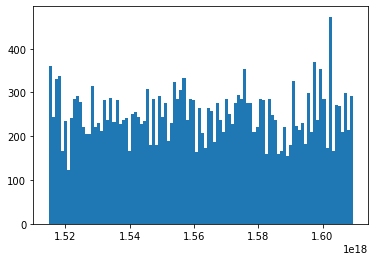

In [23]:
plt.hist(data['op_ts'],100)

In [30]:
data['op_date']

0      2018-01-01 11:16:00
1      2018-01-01 12:15:00
2      2018-01-01 15:13:00
3      2018-01-01 12:45:00
4      2018-01-01 20:27:00
               ...        
9995   2020-12-31 15:55:00
9996   2020-12-31 22:49:00
9997   2020-12-31 11:58:00
9998   2020-12-31 19:30:00
9999   2020-12-31 14:58:00
Name: op_date, Length: 25016, dtype: datetime64[ns]

In [31]:
data.sort_values(by=['user_name', 'op_ts']).reset_index(drop=True)

action auth_type browser_source browser_type browser_version  \
0      login       otp        desktop         edge         edge 93   
1      login       pwd        desktop       chrome       chrome 90   
2      login        qr        desktop         edge         edge 93   
3        sso       NaN        desktop       chrome       chrome 90   
4      login       otp        desktop         edge         edge 93   
...      ...       ...            ...          ...             ...   
25011  login       pwd        desktop       chrome       chrome 90   
25012    sso       NaN        desktop         edge         edge 93   
25013    sso       NaN        desktop       chrome       chrome 90   
25014  login       pwd        desktop       chrome       chrome 90   
25015    sso       NaN        desktop         edge         edge 93   

      bus_system_code client_type    device_model               ip  \
0       reimbursement         web  think_pad_e460  192.168.100.101   
1       reimbursement         web  think_pad_e460  192.168.100.101   
2          order-mgnt         web  think_pad_e460  192.168.100.101   
3       reimbursement         web  think_pad_e460  192.168.100.101   
4                  oa         web  think_pad_e460  192.168.100.101   
...               ...         ...             ...              ...   
25011   reimbursement         web  think_pad_e460  192.168.100.101   
25012      order-mgnt         web  think_pad_e460  192.168.100.101   
25013             crm         web  think_pad_e460  192.168.100.101   
25014      order-mgnt         web  think_pad_e460  192.168.100.101   
25015             crm         web  think_pad_e460  192.168.100.101   

      ip_location_type_keyword ip_risk_level  \
0                           内网            1级   
1                           内网            1级   
2                           内网            1级   
3                           内网            1级   
4                           内网            1级   
...                        ...           ...   
25011                       内网            1级   
25012                       内网            1级   
25013                       内网            1级   
25014                       内网            1级   
25015                       内网            1级   

                                                location             op_date  \
0      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2018-01-07 09:08:00   
1      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2018-01-07 09:27:00   
2      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2018-01-07 09:32:00   
3      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2018-01-07 09:38:00   
4      {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2018-01-07 09:40:00   
...                                                  ...                 ...   
25011  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2020-12-24 22:13:00   
25012  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2020-12-24 22:33:00   
25013  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2020-12-24 22:39:00   
25014  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2020-12-24 22:51:00   
25015  {"first_lvl":"成都分公司","sec_lvl":"9楼","third_lvl... 2020-12-24 23:11:00   

        op_target  os_type  os_version  risk_label  \
0         finance  windows  windows 10       0.000   
1         finance  windows  windows 10       1.000   
2           sales  windows  windows 10       0.000   
3         finance  windows  windows 10       0.000   
4      management  windows  windows 10       0.000   
...           ...      ...         ...         ...   
25011     finance  windows  windows 10         nan   
25012       sales  windows  windows 10         nan   
25013       sales  windows  windows 10         nan   
25014       sales  windows  windows 10         nan   
25015       sales  windows  windows 10         nan   

                              session_id user_name                op_ts  
0      access:test_a:20180107090803:WZc0    test_a  15153160800

In [16]:
data['op_date'].dt.date

0       2018-01-01
1       2018-01-01
2       2018-01-01
3       2018-01-01
4       2018-01-01
           ...    
9995    2020-12-31
9996    2020-12-31
9997    2020-12-31
9998    2020-12-31
9999    2020-12-31
Name: op_date, Length: 25016, dtype: object

In [21]:
data['date'] = data['op_date'].dt.date
data.groupby(['user_name','date'])['op_ts'].rank()

0        1.000
1        2.000
2        3.000
3        4.000
4        5.000
         ...  
25011   51.000
25012   52.000
25013   53.000
25014   54.000
25015   55.000
Name: op_ts, Length: 25016, dtype: float64

In [23]:
data['dayofweek'] = data['op_date'].dt.dayofweek

In [24]:
data.groupby(['dayofweek']).agg({'risk_label':'mean','dayofweek':'count'}).rename(columns={'risk_label':'mean','dayofweek':'count'}).reset_index()

dayofweek  mean  count
0          0 0.200   3803
1          1 0.201   3452
2          2 0.197   3318
3          3 0.203   3987
4          4 0.181   3737
5          5 0.196   3415
6          6 0.193   3304

In [25]:
data['log_times'] = data.groupby(['user_name','date'])['op_ts'].rank()

In [26]:
data.groupby(['log_times']).agg({'risk_label':'mean','log_times':'count'}).rename(columns={'risk_label':'mean','log_times':'count'}).reset_index()

log_times  mean  count
0       1.000 0.194    439
1       2.000 0.202    439
2       3.000 0.191    439
3       4.000 0.218    439
4       5.000 0.179    439
5       6.000 0.171    439
6       7.000 0.176    439
7       8.000 0.218    439
8       9.000 0.217    439
9      10.000 0.183    439
10     11.000 0.224    439
11     12.000 0.213    439
12     13.000 0.144    439
13     14.000 0.190    439
14     15.000 0.195    439
15     16.000 0.217    439
16     17.000 0.179    439
17     18.000 0.237    439
18     19.000 0.244    439
19     20.000 0.198    439
20     21.000 0.194    439
21     22.000 0.191    439
22     23.000 0.195    439
23     24.000 0.195    439
24     25.000 0.202    439
25     26.000 0.149    439
26     27.000 0.186    439
27     28.000 0.198    439
28     29.000 0.183    439
29     30.000 0.229    439
30     31.000 0.194    439
31     32.000 0.209    439
32     33.000 0.206    439
33     34.000 0.247    439
34     35.000 0.198    439
35     36.000 0.160    439
36     37.000 0.153    439
37     38.000 0.176    439
38     39.000 0.191    439
39     40.000 0.168    439
40     41.000 0.190    439
41     42.000 0.163    439
42     43.000 0.152    439
43     44.000 0.206    439
44     45.000 0.244    439
45     46.000 0.221    439
46     47.000 0.205    439
47     48.000 0.228    439
48     49.000 0.216    376
49     50.000 0.197    310
50     51.000 0.196    310
51     52.000 0.160    310
52     53.000 0.160    310
53     54.000 0.249    310
54     55.000 0.206    310
55     56.000 0.196    262
56     57.000 0.179    223
57     58.000 0.201    223
58     59.000 0.243    223
59     60.000 0.150    223
60     61.000 0.180    223
61     62.000 0.173    223
62     63.000 0.162    108

In [27]:
data['hour'] = data['op_date'].dt.hour

In [28]:
data.groupby(['hour']).agg({'risk_label':'mean','hour':'count'}).rename(columns={'risk_label':'mean','hour':'count'}).reset_index()

hour  mean  count
0      9 0.195   1693
1     10 0.188   1820
2     11 0.202   1810
3     12 0.198   1797
4     13 0.207   1713
5     14 0.208   1744
6     15 0.187   1756
7     16 0.182   1742
8     17 0.205   1757
9     18 0.181   1764
10    19 0.207   1732
11    20 0.184   1847
12    21 0.203   1771
13    22 0.187   1733
14    23 0.238    337

In [29]:
train.to_csv('G:/kaggle竞赛GM之路！！！/竞赛ing/2021CCF系统认证风险预测/train_t.csv', index=False)